In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/comments_classification/train.csv')

In [4]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
pip install neattext

In [7]:
# importing text cleaning packages

import neattext as nt
import neattext.functions

In [8]:
s = data['comment_text'][3]

In [9]:
# describing the comment

docx = nt.TextFrame(s)
docx.describe()

Key      Value          
Length  : 622            
vowels  : 196            
consonants: 290            
stopwords: 62             
punctuations: 20             
special_char: 21             
tokens(whitespace): 113            
tokens(words): 116            


In [10]:
import neattext.functions as nfx

In [11]:
data['clean_comments'] = data['comment_text'].str.lower().apply(lambda x: nfx.clean_text(x, puncts=True, stopwords=True,
                                                             urls=True, emails=True, numbers=True, emojis=True,
                                                             special_char=True, phone_num=True, non_ascii=True, multiple_whitespaces=True,
                                                             contractions=True, currency_symbols=True, custom_pattern=r'@\S+'))

In [12]:
data['clean_comments'] = data['comment_text'].str.lower()

In [13]:
data_sev = data.loc[:,['id','clean_comments','severe_toxic']]

In [14]:
data_obs = data.loc[:,['id','clean_comments','obscene']]

In [15]:
data_thr = data.loc[:,['id','clean_comments','threat']]

In [16]:
data_ins = data.loc[:,['id','clean_comments','insult']]

In [17]:
data_ide = data.loc[:,['id','clean_comments','identity_hate']]

In [18]:
data_tox = data.loc[:,['id','clean_comments','toxic']]

In [19]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [20]:
def wordcloud(df, label):
    
    # Print only rows where the toxic category label value is 1 (ie. the comment is toxic)
    subset=df[df[label]==1]
    text=subset.clean_comments.values

    wc = WordCloud(collocations=False).generate(' '.join(text))

    plt.figure(figsize=(30,30))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

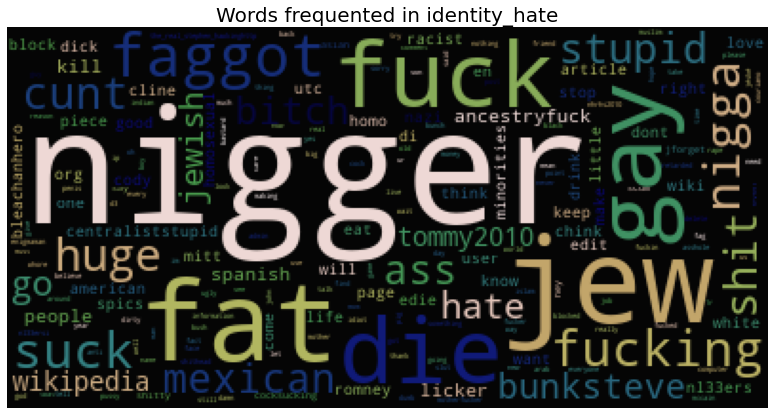

In [22]:
wordcloud(data_ide,'identity_hate')

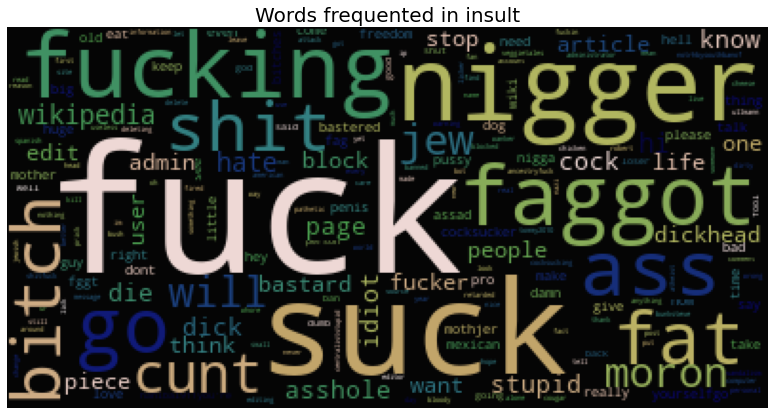

In [23]:
wordcloud(data_ins, 'insult')

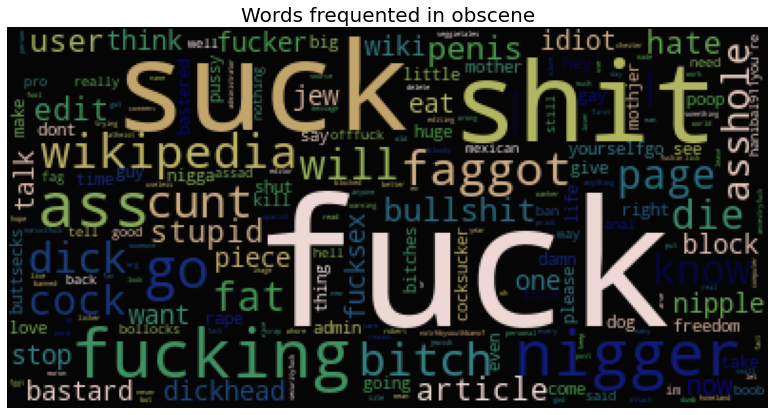

In [25]:
wordcloud(data_obs, 'obscene')

In [44]:
Y = pd.get_dummies(data_tox_done['toxic']).values

In [38]:
Y

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_tox_done['clean_comments'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38417 unique tokens.


In [41]:
X = tokenizer.texts_to_sequences(data_tox_done['clean_comments'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [26]:
Y

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [28]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6700, 250) (6700, 2)
(3300, 250) (3300, 2)


In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
95/95 [==============================] - 86s 844ms/step - loss: 0.5219 - accuracy: 0.7393 - val_loss: 0.3229 - val_accuracy: 0.8657
Epoch 2/20
31/95 [========>.....................] - ETA: 52s - loss: 0.2567 - accuracy: 0.9128

KeyboardInterrupt: ignored

In [32]:
pip install imbalanced-learn

In [33]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [34]:
# toxic comments

toxic = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]

In [35]:
# non toxic comments

non_toxic = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]
non_toxic.head()

,id,clean_comments,toxic
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i'm s...,0
2,000113f07ec002fd,"hey man, i'm really not trying to edit war. it...",0
3,0001b41b1c6bb37e,"""\nmore\ni can't make any real suggestions on ...",0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0


In [ ]:
non_toxic.shape

(5000, 3)

In [36]:
data_tox_done = pd.concat([toxic, non_toxic], axis=0)
data_tox_done.shape

(10000, 3)

In [51]:
accr = model.evaluate(X_test, y_test)
print('Test Set\n Loss: {:0.3}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

104/104 [==============================] - 12s 111ms/step - loss: 0.5338 - accuracy: 0.8670
Test Set
 Loss: 0.534
 Accuracy: 0.867


In [81]:
import os

In [82]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.SpatialDropout1D(0.2))
model.add(tf.keras.layers.Conv1D(kernel_size = 3, filters = 32))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

checkpoint_path = "/content/drive/MyDrive/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[cp_callback, es_callback])

Epoch 1/5


ValueError: ignored

In [74]:

from keras import layers, models
def create_embedding_model(vocab_size, max_length):
    model=models.Sequential()
    model.add(layers.Embedding(vocab_size, 100, input_length=max_length))
    model.add(layers.Conv1D(128, 6, activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 12, activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(32, 18, activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dense(2,  activation="sigmoid"))   
    return model

In [75]:
embedding_model = create_embedding_model(vocab_size=MAX_NB_WORDS, max_length=MAX_SEQUENCE_LENGTH)
embedding_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 conv1d_3 (Conv1D)           (None, 245, 128)          76928     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 122, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 111, 64)           98368     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 55, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 38, 32)          

In [76]:
embedding_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [86]:
checkpoint_path = "/content/drive/MyDrive/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [87]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = embedding_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[cp_callback, es_callback])

Epoch 1/5
95/95 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9942
Epoch 00001: saving model to /content/drive/MyDrive/training_1/cp.ckpt
95/95 [==============================] - 40s 419ms/step - loss: 0.0145 - accuracy: 0.9942 - val_loss: 1.2313 - val_accuracy: 0.8060
Epoch 2/5
45/95 [=============>................] - ETA: 23s - loss: 0.0103 - accuracy: 0.9958

KeyboardInterrupt: ignored

In [88]:
!pwd

/content


In [77]:
history = embedding_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
95/95 [==============================] - 40s 416ms/step - loss: 0.6253 - accuracy: 0.6436 - val_loss: 0.4987 - val_accuracy: 0.7612
Epoch 2/5
95/95 [==============================] - 39s 412ms/step - loss: 0.3496 - accuracy: 0.8496 - val_loss: 0.4369 - val_accuracy: 0.8030
Epoch 3/5
95/95 [==============================] - 39s 411ms/step - loss: 0.1595 - accuracy: 0.9302 - val_loss: 0.5509 - val_accuracy: 0.8015
Epoch 4/5
95/95 [==============================] - 39s 415ms/step - loss: 0.0778 - accuracy: 0.9698 - val_loss: 0.6941 - val_accuracy: 0.8119
Epoch 5/5
95/95 [==============================] - 39s 413ms/step - loss: 0.0550 - accuracy: 0.9786 - val_loss: 0.6902 - val_accuracy: 0.8134


In [78]:
accr = embedding_model.evaluate(X_test, y_test)
print('Test Set\n Loss: {:0.3}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

104/104 [==============================] - 4s 42ms/step - loss: 0.8173 - accuracy: 0.8076
Test Set
 Loss: 0.817
 Accuracy: 0.808


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)